In [1]:
import anndata as ad
import scanpy as sc
import numpy as np
import pickle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import f1_score

# Functions to make heatmap figure

In [2]:
def check_classes(prediction_classes, original_predictions, context, classifier):
    """Check if all classes are included and print a message accordingly."""
    if len(set(prediction_classes)) == len(original_predictions):
        print(f"{context} classes OK {classifier}")
    else:
        print(f"Some predicted class not included in {context}")

In [3]:
def make_and_filter_confmatrix(actual_labels, predicted_labels, actual_classes, prediction_classes):
    #Create matrix to plot
    conf_matrix = np.zeros((len(actual_classes), len(prediction_classes)))
    for i in range(len(actual_classes)):
        for j in range(len(prediction_classes)):
            conf_matrix[i, j] = np.sum((actual_labels==actual_classes[i]) & (predicted_labels == prediction_classes[j]) )

    conf_matrix = conf_matrix / np.sum(conf_matrix, axis=1).reshape((-1, 1))
    
    #Reduce visible noise in heatmap, these are still kept for calculating f1-scores
    conf_matrix = np.round(conf_matrix, 2)
    conf_matrix[conf_matrix < 0.01] = 0 
    column_threshold = 0.01
    valid_columns = np.sum(conf_matrix, axis=0) > column_threshold * conf_matrix.shape[0]  
    valid_rows = np.sum(conf_matrix, axis=1) > column_threshold * conf_matrix.shape[1]  

    filtered_conf_matrix = conf_matrix[valid_rows, :][:, valid_columns]
    filtered_prediction_classes = [prediction_classes[j] for j in range(len(prediction_classes)) if valid_columns[j]]
    filtered_actual_classes = [actual_classes[i] for i in range(len(actual_classes)) if valid_rows[i]]

    mask = np.zeros_like(filtered_conf_matrix)
    mask[filtered_conf_matrix == 0] = True
    
    return filtered_conf_matrix, mask, filtered_prediction_classes, filtered_actual_classes

In [10]:
def make_heatmap_f1_score(preds, res, scpred, savestr, dataset_title, save = False, average_f1 = 'weighted'):
    fig, ax = plt.subplots(1,3, figsize = (30,10))
    ax=ax.flatten()
    
    #label dictionary to make sure each cell type name in the predictions matches the cell types in the tested dataset
    label_dictionary= {'B':'B', 'Plasma B': 'Plasma B', 'CD4T':'CD4T', 'CD8T':'CD8T', 'NK':'NK', 'Classical Monocyte':'CM', 'Non-classical Monocyte':'nCM', 'DC':'DC', 'pDC':'pDC', 'Erythrocyte':'RBC', 'Platelet':'Platelet', 'Neutrophil':'Neutrophil', 'Granulocyte':'Granulocyte', 'Granulocytes':'Granulocyte',
                      'γδ-T cells':'γδ-T cells', 'Progenitor cells':'Progenitor cells', 'HSC/MPP cells':'HSC/MPP cells'}
    
    cmap_chosen = 'Blues'
    
    ########################################################################
    #BLC
    
    potential_actual_classes = ['B', 'Plasma B', 'CD4T', 'CD8T', 'NK', 'Classical Monocyte', 'Non-classical Monocyte', 'DC', 'pDC', 'Platelet', 'Neutrophil', 'Granulocyte', 'Erythrocyte', 'Granulocytes']
    original_cts = list(set(res.CellType))
    actual_classes = []
    for ct in potential_actual_classes:
        if ct in original_cts:
            actual_classes += [ct]

    potential_prediction_classes = ['B', 'Plasma B', 'CD4T', 'CD8T', 'NK', 'Classical Monocyte', 'Non-classical Monocyte', 'DC', 'pDC', 'Platelet', 'Neutrophil', 'Granulocyte', 'Erythrocyte', 'Granulocytes']
    prediction_classes = []
    original_predictions = list(set(preds.ct_pred))

    for ct in potential_prediction_classes:
        if ct in original_predictions:
            prediction_classes += [ct]

    #check if prediction classes and original predictions match up:
    check_classes(prediction_classes, original_predictions, 'prediction', 'BLC')
    check_classes(actual_classes, original_cts, 'actual classes', 'BLC')
  
    #Make the confmatrix to plot:
    filtered_conf_matrix, mask, filtered_prediction_classes, filtered_actual_classes = make_and_filter_confmatrix(preds.CellType, preds.ct_pred, actual_classes, prediction_classes)
    sns.heatmap(filtered_conf_matrix, mask=mask, cmap = cmap_chosen, annot=True, annot_kws={"fontsize":18}, ax = ax[0], alpha = 0.9)

    # Update labels for filtered classes
    labels_predictions = [label_dictionary[x] for x in filtered_prediction_classes]
    labels_actuals = [label_dictionary[x] for x in filtered_actual_classes]

    ax[0].set_xticks(ticks=np.arange(len(filtered_prediction_classes))+0.5, labels=labels_predictions, rotation=45, ha='right', fontsize=18)
    ax[0].set_yticks(ticks=np.arange(len(filtered_actual_classes))+0.5, labels=labels_actuals, rotation=0, ha='right', fontsize=18)
    ax[0].set_xlabel('Predicted class', fontsize=20)
    ax[0].set_ylabel('Actual class', fontsize=20)

    #Calculate f1-scores
    f1 = f1_score(preds.ct_pred, preds.CellType, average = average_f1)
    f1 = str(np.round(f1, 2))
    ax[0].set_title('F1-score BLC: '+str(f1), fontsize = 22)    


    ########################################################################
    #SCTYPE


    potential_prediction_classes = ['B', 'Plasma B', 'CD4T', 'CD8T', 'NK', 'Classical Monocyte', 'Non-classical Monocyte', 'DC', 'pDC', 'Platelet', 'Neutrophil', 'Granulocyte', 'Granulocytes', 'ISGs', 'γδ-T cells', 'Progenitor cells', 'Erythrocyte', 'Unknown', 'HSC/MPP cells']
    prediction_classes = []
    original_predictions = list(set(res.ct_pred))
    for ct in potential_prediction_classes:
        if ct in original_predictions:
            prediction_classes += [ct]
            
    #check if prediction classes and original predictions match up:
    check_classes(prediction_classes, original_predictions, 'prediction', 'scType')
    check_classes(actual_classes, original_cts, 'actual classes', 'scType')
  
    #Make the confmatrix to plot:
    filtered_conf_matrix, mask, filtered_prediction_classes, filtered_actual_classes = make_and_filter_confmatrix(res.CellType, res.ct_pred, actual_classes, prediction_classes)
    sns.heatmap(filtered_conf_matrix, mask=mask, cmap = cmap_chosen, annot=True, annot_kws={"fontsize":18}, ax = ax[1], alpha = 0.9)

    # Update labels for filtered classes
    labels_predictions = [label_dictionary[x] for x in filtered_prediction_classes]
    labels_actuals = [label_dictionary[x] for x in filtered_actual_classes]

    ax[1].set_xticks(ticks=np.arange(len(filtered_prediction_classes))+0.5, labels=labels_predictions, rotation=45, ha='right', fontsize=18)
    ax[1].set_yticks(ticks=np.arange(len(filtered_actual_classes))+0.5, labels=labels_actuals, rotation=0, ha='right', fontsize=18)
    ax[1].set_xlabel('Predicted class', fontsize=20)
    ax[1].set_ylabel('Actual class', fontsize=20)

    f1 = f1_score(res.ct_pred, res.CellType, average = average_f1)
    f1 = str(np.round(f1, 2))
    ax[1].set_title('F1-score scType: '+str(f1), fontsize = 22)#+' \n Dataset: '+str('egad_190109_lane1'))
    
    
    ########################################################################
    #SCPRED

    potential_prediction_classes = ['B', 'Plasma B', 'CD4T', 'CD8T', 'NK', 'Classical Monocyte', 'Non-classical Monocyte', 'DC', 'pDC', 'Platelet', 'Neutrophil', 'Granulocyte', 'Granulocytes', 'Erythrocyte', 'Unknown']
    prediction_classes = []
    original_predictions = list(set(scpred.ct_pred))
    for ct in potential_prediction_classes:
        if ct in original_predictions:
            prediction_classes += [ct]

    #check if prediction classes and original predictions match up:
    check_classes(prediction_classes, original_predictions, 'prediction', 'scPred')
    check_classes(actual_classes, original_cts, 'actual classes', 'scPred')
  
    #Make the confmatrix to plot:
    filtered_conf_matrix, mask, filtered_prediction_classes, filtered_actual_classes = make_and_filter_confmatrix(scpred.CellType, scpred.ct_pred, actual_classes, prediction_classes)

    sns.heatmap(filtered_conf_matrix, mask=mask, cmap = cmap_chosen, annot=True, annot_kws={"fontsize":18}, ax = ax[2], alpha = 0.9)

    # Update labels for filtered classes
    labels_predictions = [label_dictionary[x] for x in filtered_prediction_classes]
    labels_actuals = [label_dictionary[x] for x in filtered_actual_classes]

    ax[2].set_xticks(ticks=np.arange(len(filtered_prediction_classes))+0.5, labels=labels_predictions, rotation=45, ha='right', fontsize=18)
    ax[2].set_yticks(ticks=np.arange(len(filtered_actual_classes))+0.5, labels=labels_actuals, rotation=0, ha='right', fontsize=18)
    ax[2].set_xlabel('Predicted class', fontsize=20)
    ax[2].set_ylabel('Actual class', fontsize=20)

    f1 = f1_score(scpred.ct_pred, scpred.CellType, average = average_f1)
    f1 = str(np.round(f1, 2))
    #plt.title('F1-score: %s \n Dataset: %s\n nFeatures: %s'%(f1%data_name%nfeatures))
    ax[2].set_title('F1-score scPred: '+str(f1), fontsize = 22)#+' \n Dataset: '+str('egad_190109_lane1'))
    
    
    ########################################################################
    plt.suptitle(dataset_title, fontsize = 30)
    plt.tight_layout()
    if save:
        plt.savefig('./' + savestr, format = 'svg', bbox_inches = 'tight', dpi = 300)

# Figure 2A SmartSeq 

In [11]:
#SmartSeq3
preds = pd.read_csv('../../classifiers_results/test_data/BLC_SmartSeq3RESULTS.csv')

#ScType:
data_sctype = '../../classifiers_results/test_data/scType_SmartSeq3RESULTS.csv'

res = pd.read_csv(data_sctype, sep = ';')
res['ct_pred'] = res['customclassif'].copy()
#res = res.rename(columns = {'customclassif':'ct_pred'})
ct_dic = {'Naive B cells':'B', 'Pre-B cells':'B',  'Plasmacytoid Dendritic cells': 'pDC', 'Non-classical monocytes':'Non-classical Monocyte', 'Natural killer  cells':'NK', 'Naive CD4+ T cells': 'CD4T', 'CD8+ NKT-like cells':'CD8T', 'Classical Monocytes':'Classical Monocyte', 'Platelets':'Platelet', 'Myeloid Dendritic cells': 'DC', 'γδ-T cells':'γδ-T cells', 
          'Effector CD8+ T cells':'CD8T', 'Memory CD4+ T cells': 'CD4T', 'Naive CD8+ T cells': 'CD8T', 'Effector CD4+ T cells':'CD4T', 'Memory CD8+ T cells':'CD8T', 
         'ISG expressing immune cells':'ISGs', 'Memory B cells':'B', 'Macrophages':'Macrophages', 'Megakaryocyte':'Megakaryocyte', 'Plasma B cells':'Plasma B', 'Progenitor cells': 'Progenitor cells', 'Erythroid-like and erythroid precursor cells': 'Erythroid-like and erythroid precursor cells',
         'Basophils':'Basophils', 'Neutrophils':'Neutrophil', 'Granulocytes':'Granulocytes', 'HSC/MPP cells':'HSC/MPP cells', 'Unknown':'Unknown', 'Erythroid-like and erythroid precursor cells':'Erythrocyte'}

res['ct_pred'] = res['ct_pred'].apply(lambda x: ct_dic[x])
res.ct_pred = res.ct_pred.astype(str)
res.CellType = res.CellType.astype(str)


#For "Macrophages" - we are being nice here and setting it according to their original CellType
inds = res[res.ct_pred == 'Macrophages'].index
res.loc[inds, 'ct_pred'] = res.loc[inds, 'CellType']

#For "ISGs" - we are being nice here and setting it according to their original CellType
inds = res[res.ct_pred == 'ISGs'].index
res.loc[inds, 'ct_pred'] = res.loc[inds, 'CellType']

scpred = pd.read_csv('../../classifiers_results/test_data/scPred_SmartSeq3RESULTS.csv', sep = ';')
scpred['ct_pred'] = scpred.scpred_no_rejection.copy()

prediction classes OK BLC
actual classes classes OK BLC
prediction classes OK scType
actual classes classes OK scType
prediction classes OK scPred
actual classes classes OK scPred


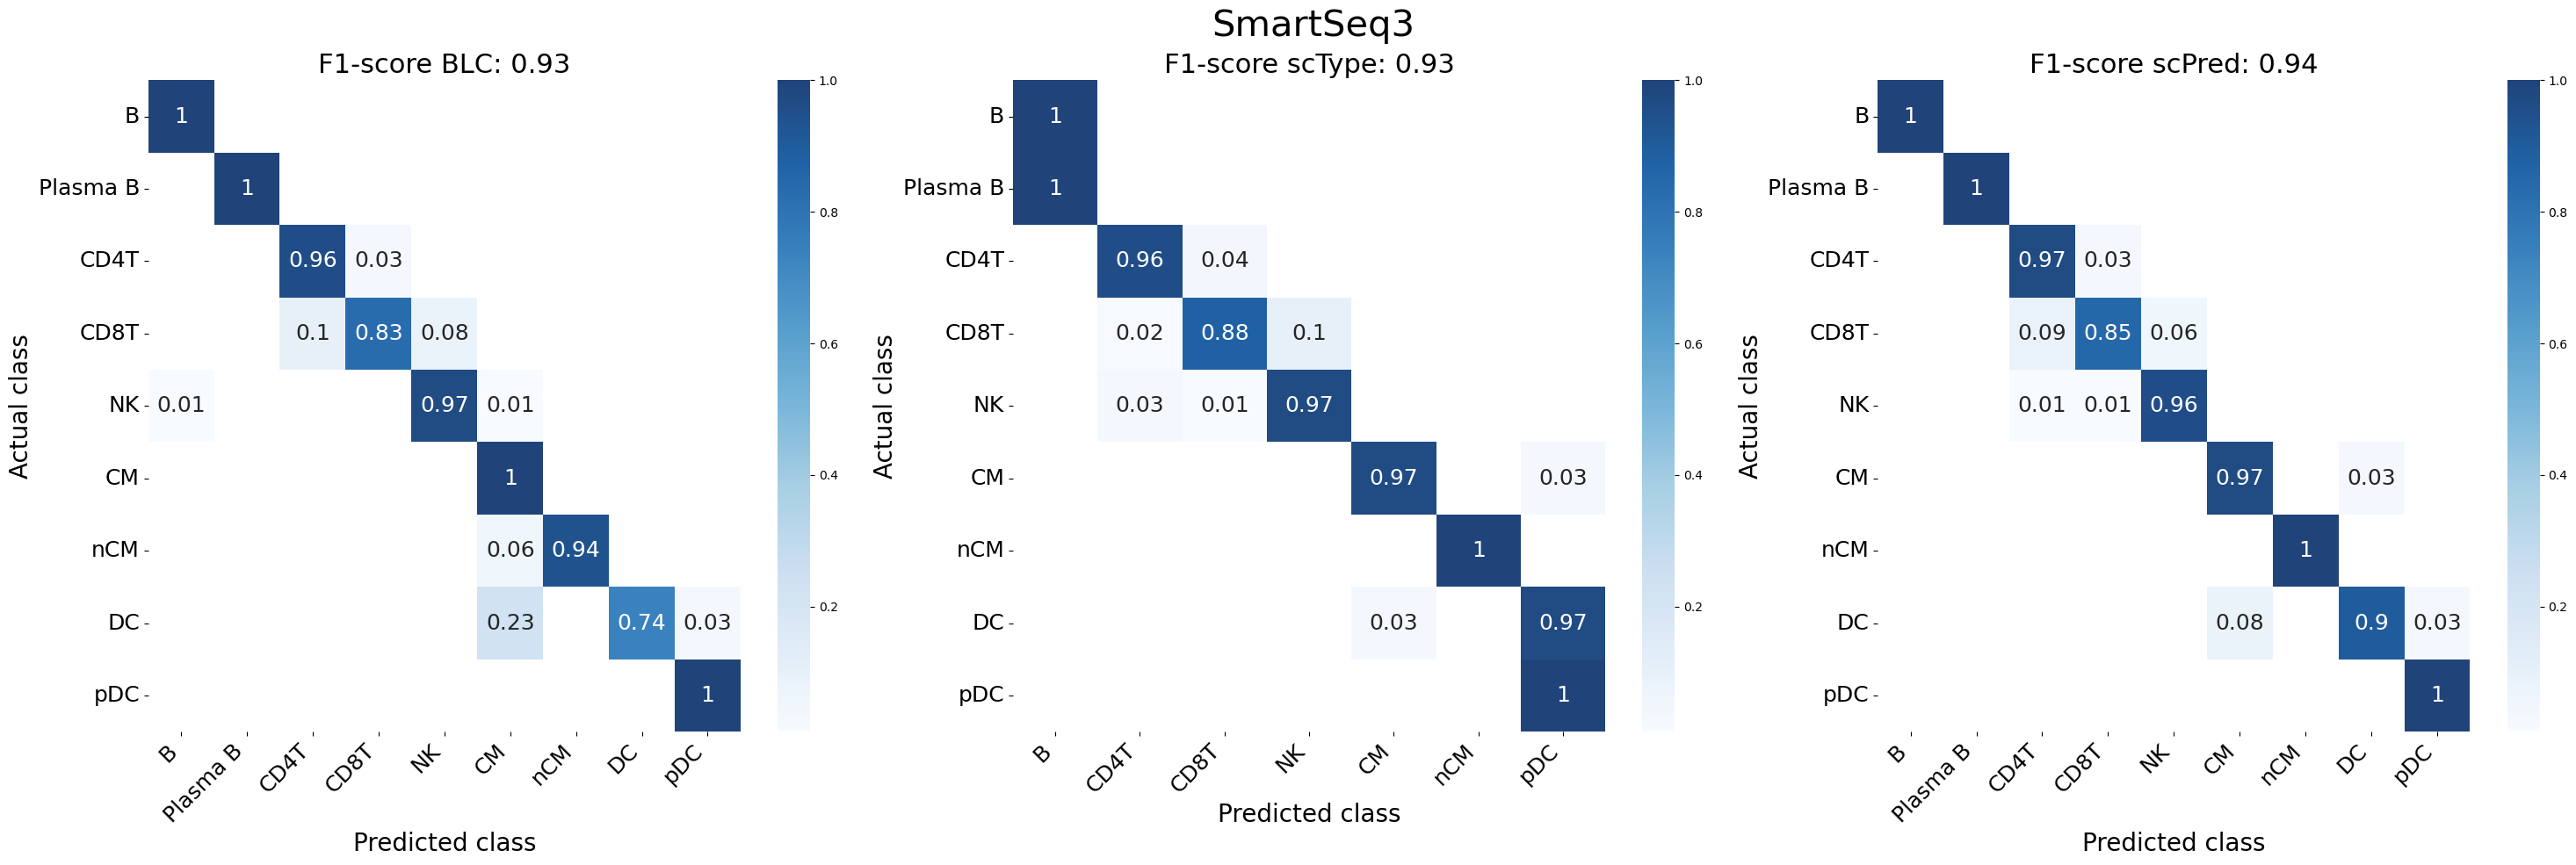

In [14]:
make_heatmap_f1_score(preds, res, scpred, dataset_title = 'SmartSeq3', save = False, savestr = 'Figure2A_SmartSeq3.svg', average_f1 = 'micro')

# Figure 2B Healthy controls from Lee et al, HC

In [15]:
#Lee et al HC:
#BLC:
preds =  pd.read_csv('../../classifiers_results/test_data/BLC_LeeHCRESULTS.csv')

#ScType:
data_sctype = '../../classifiers_results/test_data/scType_LeeHCRESULTS.csv'

res = pd.read_csv(data_sctype, sep = ';')
res['ct_pred'] = res['customclassif'].copy()

ct_dic = {'Naive B cells':'B', 'Pre-B cells':'B',  'Plasmacytoid Dendritic cells': 'pDC', 'Non-classical monocytes':'Non-classical Monocyte', 'Natural killer  cells':'NK', 'Naive CD4+ T cells': 'CD4T', 'CD8+ NKT-like cells':'CD8T', 'Classical Monocytes':'Classical Monocyte', 'Platelets':'Platelet', 'Myeloid Dendritic cells': 'DC', 'γδ-T cells':'γδ-T cells', 
          'Effector CD8+ T cells':'CD8T', 'Memory CD4+ T cells': 'CD4T', 'Naive CD8+ T cells': 'CD8T', 'Effector CD4+ T cells':'CD4T', 'Memory CD8+ T cells':'CD8T', 
         'ISG expressing immune cells':'ISGs', 'Memory B cells':'B', 'Macrophages':'Macrophages', 'Megakaryocyte':'Megakaryocyte', 'Plasma B cells':'Plasma B', 'Progenitor cells': 'Progenitor cells', 'Erythroid-like and erythroid precursor cells': 'Erythroid-like and erythroid precursor cells',
         'Basophils':'Basophils', 'Neutrophils':'Neutrophil', 'Granulocytes':'Granulocytes', 'HSC/MPP cells':'HSC/MPP cells', 'Unknown':'Unknown', 'Erythroid-like and erythroid precursor cells':'Erythrocyte'}

res['ct_pred'] = res['ct_pred'].apply(lambda x: ct_dic[x])
res.ct_pred = res.ct_pred.astype(str)
res.CellType = res.CellType.astype(str)


#For "Macrophages" - set it to their original CellType
inds = res[res.ct_pred == 'Macrophages'].index
res.loc[inds, 'ct_pred'] = res.loc[inds, 'CellType']

#For "ISGs" - set it to their original CellType
inds = res[res.ct_pred == 'ISGs'].index
res.loc[inds, 'ct_pred'] = res.loc[inds, 'CellType']


#SCPRED:
scpred = pd.read_csv('../../classifiers_results/test_data/scPred_LeeHCRESULTS.csv', sep = ';')
scpred['ct_pred'] = scpred.scpred_no_rejection.copy()

prediction classes OK BLC
actual classes classes OK BLC
prediction classes OK scType
actual classes classes OK scType
prediction classes OK scPred
actual classes classes OK scPred


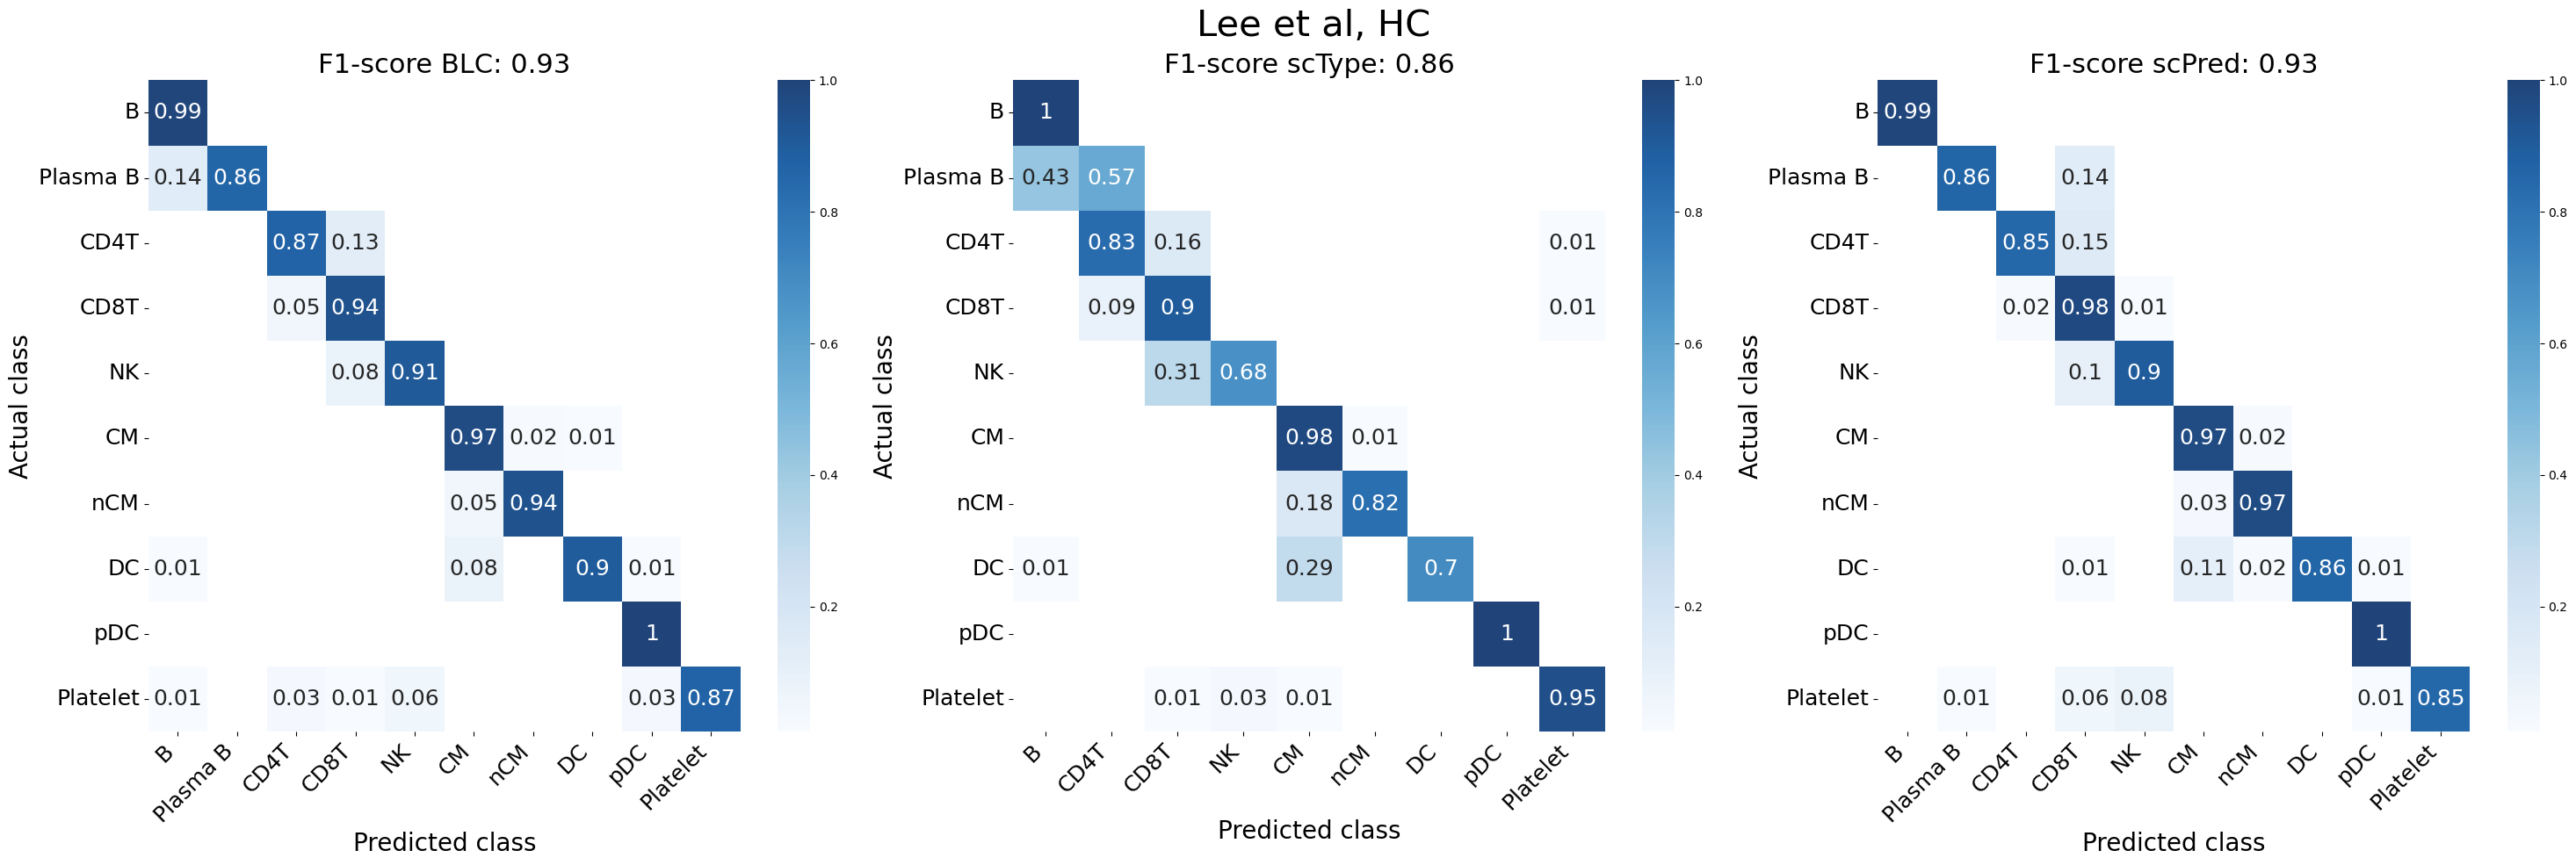

In [16]:
make_heatmap_f1_score(preds, res, scpred, dataset_title = 'Lee et al, HC', save = False, savestr = 'Figure2B_LeeHC.svg', average_f1 = 'micro')

# Figure 2C - Oelen et al

In [26]:
#Lee et al HC:
#BLC:
preds =  pd.read_csv('../../classifiers_results/test_data/BLC_OelenRESULTS.csv')

#ScType:
data_sctype = data_sctype = '../../classifiers_results/test_data/scType_OelenRESULTS.csv'


res = pd.read_csv(data_sctype, sep = ';')
res['ct_pred'] = res['customclassif'].copy()

ct_dic = {'Naive B cells':'B', 'Pre-B cells':'B',  'Plasmacytoid Dendritic cells': 'pDC', 'Non-classical monocytes':'Non-classical Monocyte', 'Natural killer  cells':'NK', 'Naive CD4+ T cells': 'CD4T', 'CD8+ NKT-like cells':'CD8T', 'Classical Monocytes':'Classical Monocyte', 'Platelets':'Platelet', 'Myeloid Dendritic cells': 'DC', 'γδ-T cells':'γδ-T cells', 
          'Effector CD8+ T cells':'CD8T', 'Memory CD4+ T cells': 'CD4T', 'Naive CD8+ T cells': 'CD8T', 'Effector CD4+ T cells':'CD4T', 'Memory CD8+ T cells':'CD8T', 
         'ISG expressing immune cells':'ISGs', 'Memory B cells':'B', 'Macrophages':'Macrophages', 'Megakaryocyte':'Megakaryocyte', 'Plasma B cells':'Plasma B', 'Progenitor cells': 'Progenitor cells', 'Erythroid-like and erythroid precursor cells': 'Erythroid-like and erythroid precursor cells',
         'Basophils':'Basophils', 'Neutrophils':'Neutrophil', 'Granulocytes':'Granulocytes', 'HSC/MPP cells':'HSC/MPP cells', 'Unknown':'Unknown', 'Erythroid-like and erythroid precursor cells':'Erythrocyte'}

res['ct_pred'] = res['ct_pred'].apply(lambda x: ct_dic[x])
res.ct_pred = res.ct_pred.astype(str)
res.CellType = res.CellType.astype(str)

#For "Macrophages" - set it to their original CellType
inds = res[res.ct_pred == 'Macrophages'].index
res.loc[inds, 'ct_pred'] = res.loc[inds, 'CellType']

#For "ISGs" - set it to their original CellType
inds = res[res.ct_pred == 'ISGs'].index
res.loc[inds, 'ct_pred'] = res.loc[inds, 'CellType']

scpred = pd.read_csv('../../classifiers_results/test_data/scPred_OelenRESULTS.csv', sep = ';')
scpred['ct_pred'] = scpred.scpred_no_rejection.copy()

prediction classes OK BLC
actual classes classes OK BLC
prediction classes OK scType
actual classes classes OK scType
prediction classes OK scPred
actual classes classes OK scPred


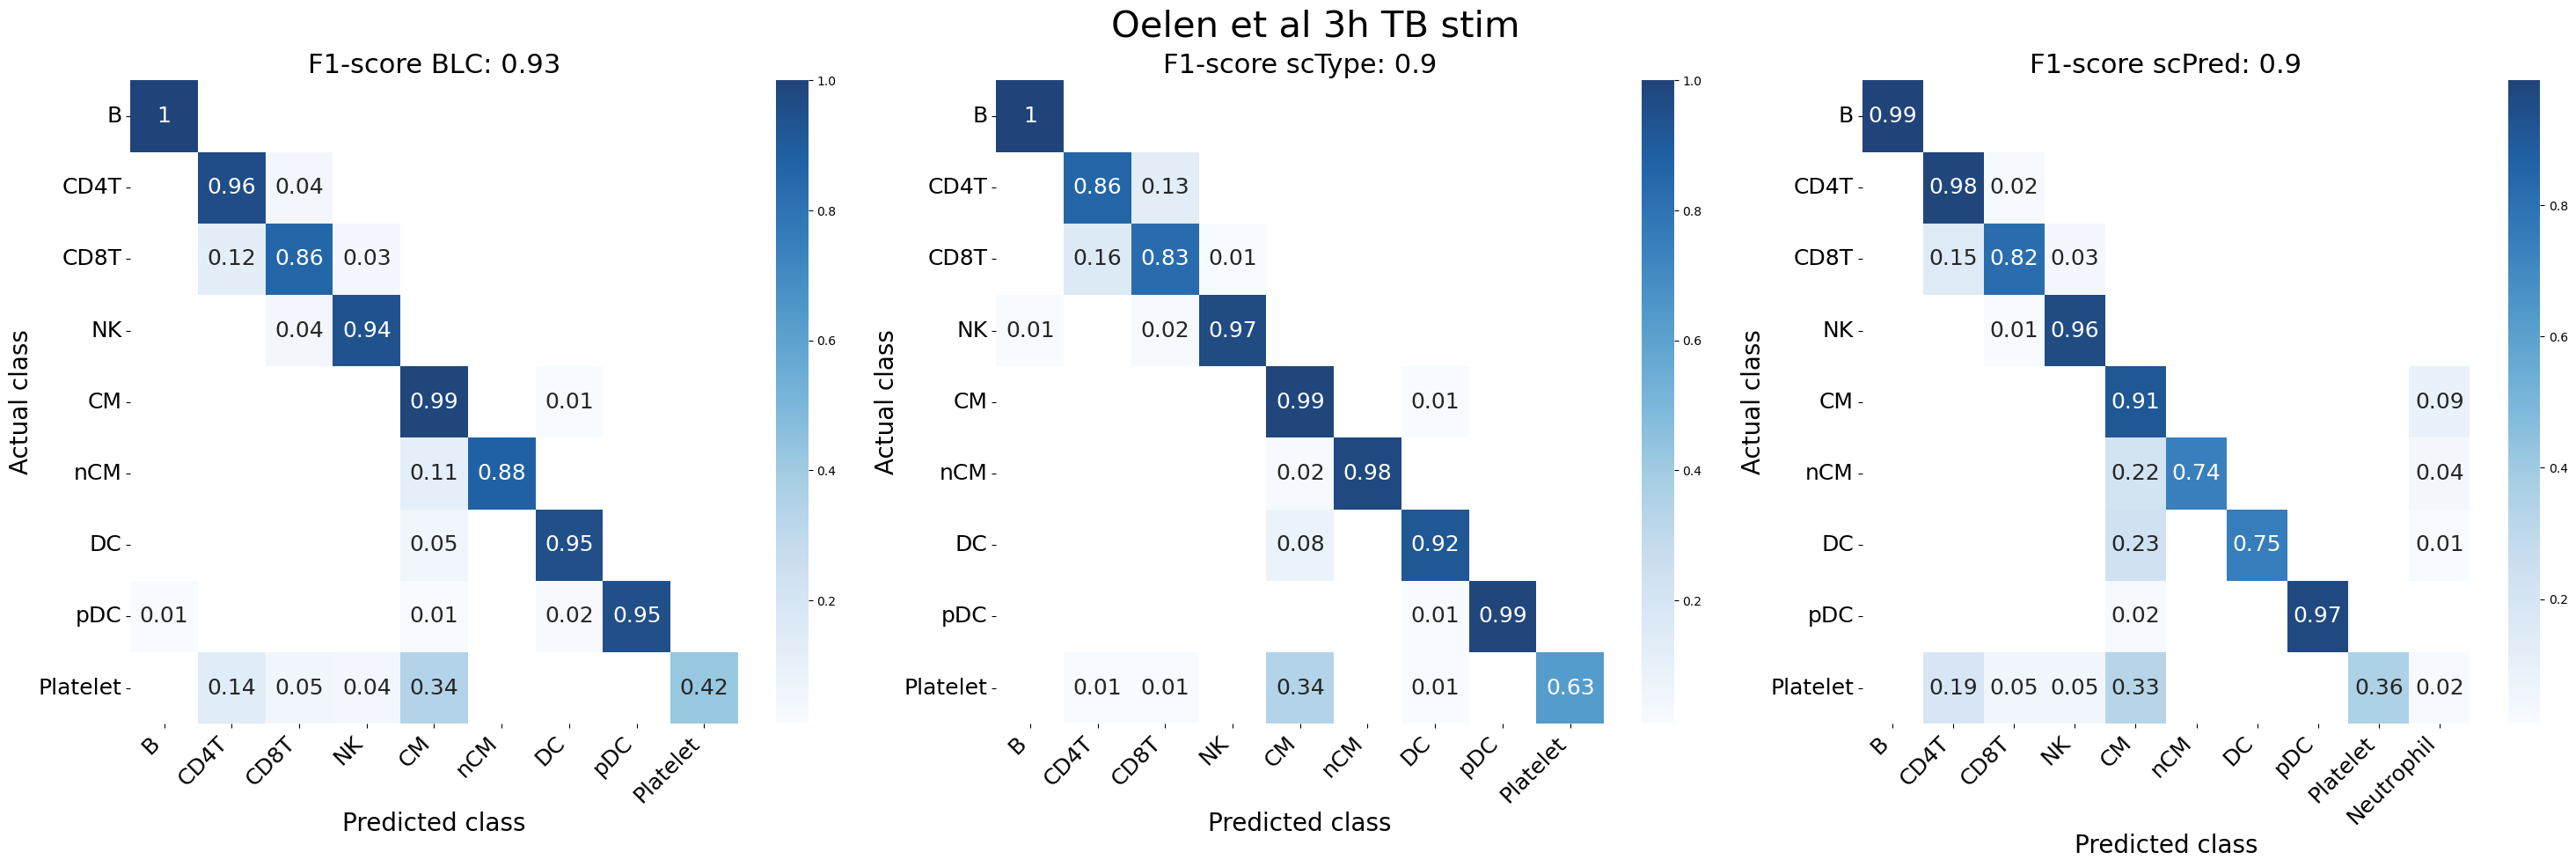

In [27]:
make_heatmap_f1_score(preds, res, scpred, dataset_title = 'Oelen et al 3h TB stim', save = False, savestr = 'Figure2C_EGAD3hTBstim.svg', average_f1 = 'micro')


# Figure 2D, Covid from Lee et al

In [29]:
#Lee et al Covid:
#BLC:
preds =  pd.read_csv('../../classifiers_results/test_data/BLC_LeeCovRESULTS.csv')

#ScType:
data_sctype = data_sctype = '../../classifiers_results/test_data/scType_LeeCovRESULTS.csv'


res = pd.read_csv(data_sctype, sep = ';')
res['ct_pred'] = res['customclassif'].copy()
ct_dic = {'Naive B cells':'B', 'Pre-B cells':'B',  'Plasmacytoid Dendritic cells': 'pDC', 'Non-classical monocytes':'Non-classical Monocyte', 'Natural killer  cells':'NK', 'Naive CD4+ T cells': 'CD4T', 'CD8+ NKT-like cells':'CD8T', 'Classical Monocytes':'Classical Monocyte', 'Platelets':'Platelet', 'Myeloid Dendritic cells': 'DC', 'γδ-T cells':'γδ-T cells', 
          'Effector CD8+ T cells':'CD8T', 'Memory CD4+ T cells': 'CD4T', 'Naive CD8+ T cells': 'CD8T', 'Effector CD4+ T cells':'CD4T', 'Memory CD8+ T cells':'CD8T', 
         'ISG expressing immune cells':'ISGs', 'Memory B cells':'B', 'Macrophages':'Macrophages', 'Megakaryocyte':'Megakaryocyte', 'Plasma B cells':'Plasma B', 'Progenitor cells': 'Progenitor cells', 'Erythroid-like and erythroid precursor cells': 'Erythroid-like and erythroid precursor cells',
         'Basophils':'Basophils', 'Neutrophils':'Neutrophil', 'Granulocytes':'Granulocytes', 'HSC/MPP cells':'HSC/MPP cells', 'Unknown':'Unknown', 'Erythroid-like and erythroid precursor cells':'Erythrocyte'}

res['ct_pred'] = res['ct_pred'].apply(lambda x: ct_dic[x])
res.ct_pred = res.ct_pred.astype(str)
res.CellType = res.CellType.astype(str)

#For "Macrophages" - we are being nice here and setting it according to their original CellType
inds = res[res.ct_pred == 'Macrophages'].index
res.loc[inds, 'ct_pred'] = res.loc[inds, 'CellType']

#For "ISGs" - we are being nice here and setting it according to their original CellType
inds = res[res.ct_pred == 'ISGs'].index
res.loc[inds, 'ct_pred'] = res.loc[inds, 'CellType']


#SCPRED:
scpred = pd.read_csv('../../classifiers_results/test_data/scPred_LeeCovRESULTS.csv', sep = ';')
scpred['ct_pred'] = scpred.scpred_no_rejection.copy()


prediction classes OK BLC
actual classes classes OK BLC
prediction classes OK scType
actual classes classes OK scType
prediction classes OK scPred
actual classes classes OK scPred


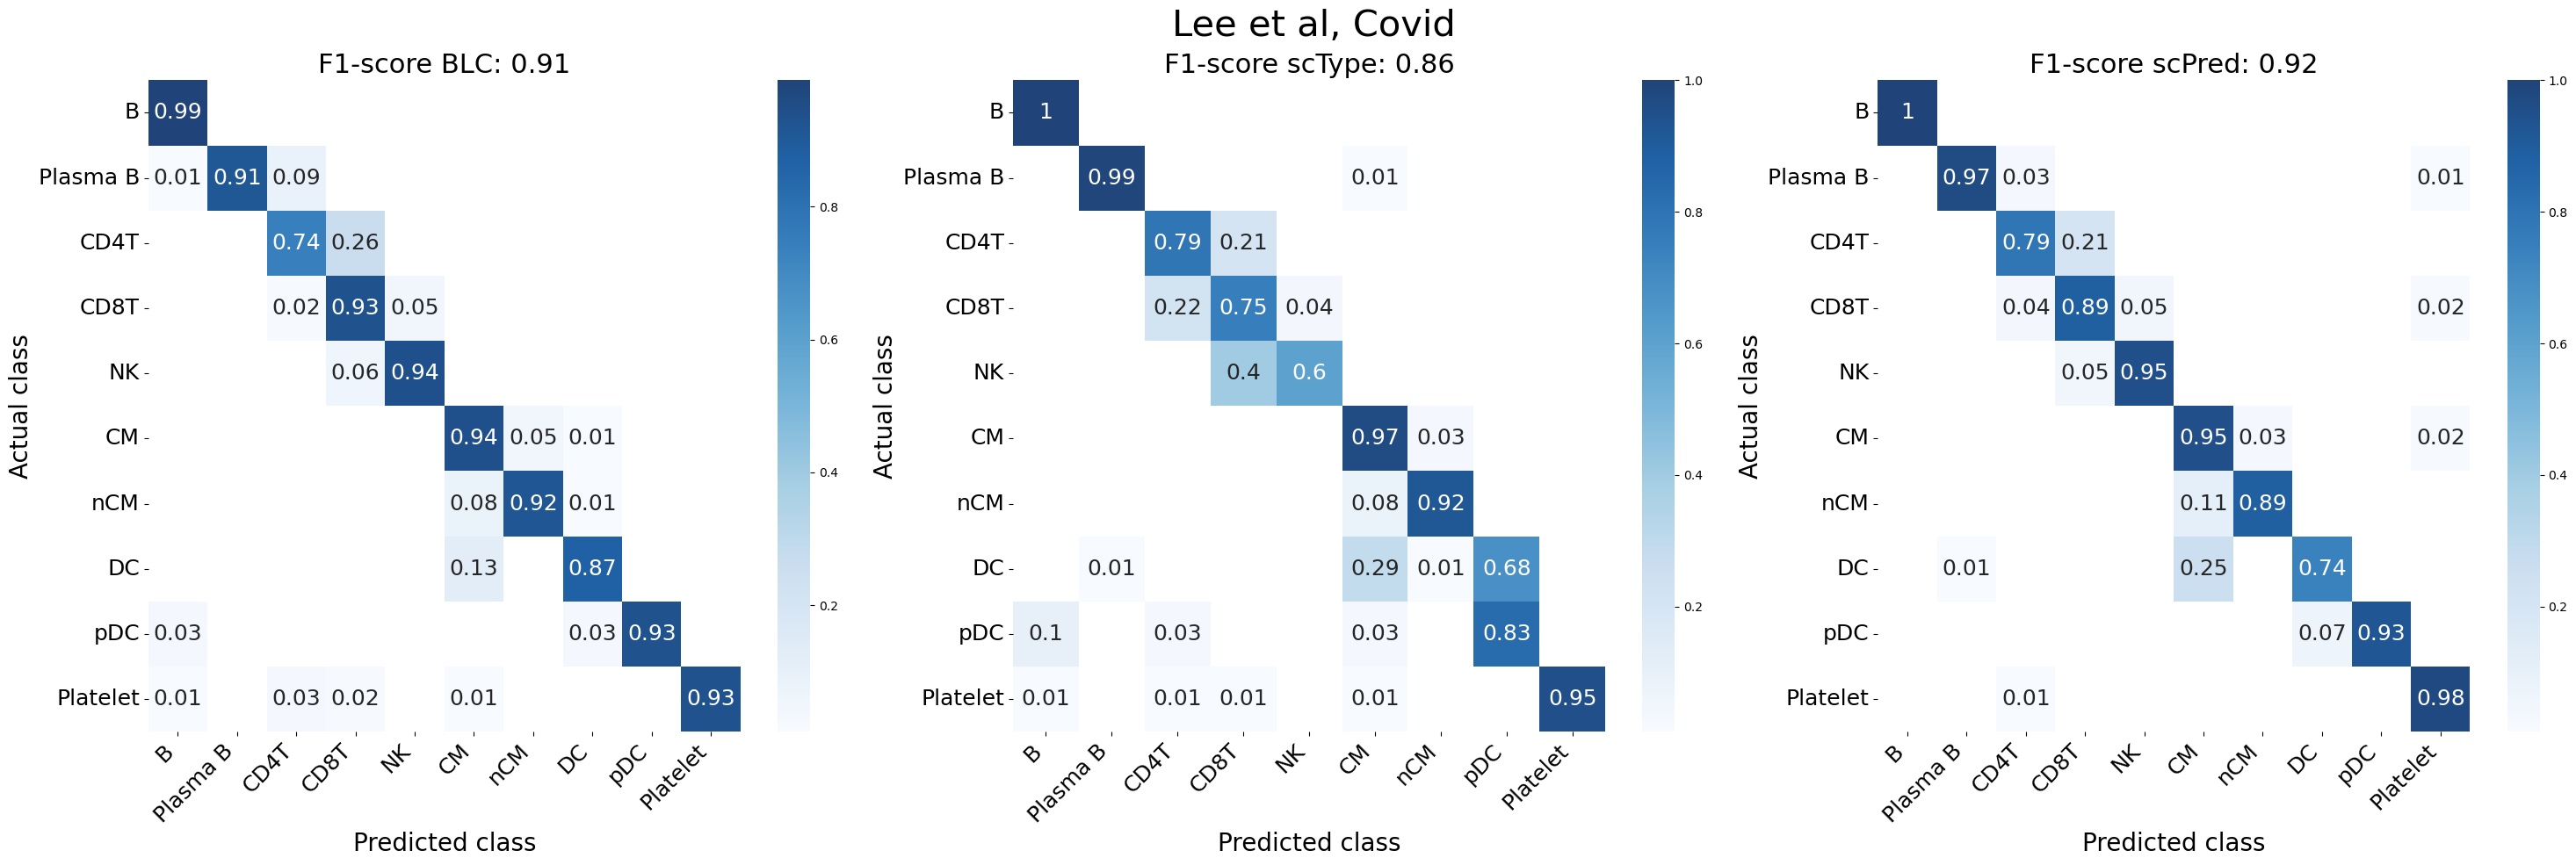

In [14]:
make_heatmap_f1_score(preds, res, scpred, dataset_title = 'Lee et al, Covid', save = False, savestr = 'Figure2D_LeeCovid.svg', average_f1 = 'micro')
